# Viola-Jones Detection with EigenFace Recognition



## Preparing the Yale Face Dataset and getting relevant files

Get the Yale Face Dataset

In [1]:
!wget https://github.com/awesomeroks/ViolaJones-EigenFace/raw/master/yalefaces.zip

--2020-10-05 12:26:56--  https://github.com/awesomeroks/ViolaJones-EigenFace/raw/master/yalefaces.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/awesomeroks/ViolaJones-EigenFace/master/yalefaces.zip [following]
--2020-10-05 12:26:57--  https://raw.githubusercontent.com/awesomeroks/ViolaJones-EigenFace/master/yalefaces.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6206308 (5.9M) [application/zip]
Saving to: ‘yalefaces.zip’

yalefaces.zip       100%[===================>]   5.92M  19.8MB/s    in 0.3s    

2020-10-05 12:26:57 (19.8 MB/s) - ‘yalefaces.zip’ saved [6206308/6206308]



In [2]:
!unzip -q yalefaces

In [3]:
!rm yalefaces/Readme.txt

In [4]:
import glob
import cv2
import os

The dataset is given in a gif format. However, all of our computation will be on jpg/png formats. 

Let us hence use the VideoCapture to convert the gif into pngs

In [5]:
os.makedirs('dataset/yalefaces/', exist_ok =  True)
for filepath in sorted(glob.glob('yalefaces/*')):
  cap = cv2.VideoCapture(filepath)
  i = 0
  filepathlist = filepath.split('.')
  ret, frame = cap.read()
  filepathlist.append(str(i))
  while ret != False:
    filepathlist.pop(-1)
    filepathlist.append(str(i))
    i+=1
    filepath = '.'.join(filepathlist) + '.png'
    cv2.imwrite('dataset/' + filepath, frame)
    ret, frame = cap.read()

Split the dataset into train and test sets and store in appropriate folders

In [6]:
  from sklearn.model_selection import train_test_split
  trainList, testList = train_test_split(os.listdir('dataset/yalefaces/'), test_size=0.2, shuffle=True)
  os.makedirs('dataset/test/', exist_ok =  True)
  os.makedirs('dataset/train/', exist_ok =  True)
  for filepath in trainList:
      filename = os.path.split(filepath)[-1]
      os.rename('dataset/yalefaces/' +  filename, 'dataset/train/'+ filename)
  for filepath in testList:
      filename = os.path.split(filepath)[-1]
      os.rename('dataset/yalefaces/' +  filename, 'dataset/test/'+ filename)

Remove all unnecessary files to keep the directory clean :)

In [7]:
!rmdir dataset/yalefaces

In [8]:
!rm -r yalefaces/

In [9]:
!rm -r sample_data

In [10]:
!rm yalefaces.zip

In [11]:
!rm -r __MACOSX

Get a pretrained HAAR cascade for getting the bounding boxes from the Yale face dataset

In [12]:
!wget -P haar/ https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml

--2020-10-05 12:27:00--  https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 930127 (908K) [text/plain]
Saving to: ‘haar/haarcascade_frontalface_default.xml’

haarcascade_frontal 100%[===================>] 908.33K  --.-KB/s    in 0.1s    

2020-10-05 12:27:01 (7.30 MB/s) - ‘haar/haarcascade_frontalface_default.xml’ saved [930127/930127]



The next cell retrieves a Haar Cascade that has been trained after executing this notebook. It has been hosted on Github as of this moment.

In [13]:
!wget -P haarTrainedCustom/ https://raw.githubusercontent.com/awesomeroks/ViolaJones-EigenFace/master/trainSet/cascade.xml

--2020-10-05 12:27:01--  https://raw.githubusercontent.com/awesomeroks/ViolaJones-EigenFace/master/trainSet/cascade.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16642 (16K) [text/plain]
Saving to: ‘haarTrainedCustom/cascade.xml’

cascade.xml         100%[===================>]  16.25K  --.-KB/s    in 0.01s   

2020-10-05 12:27:01 (1.28 MB/s) - ‘haarTrainedCustom/cascade.xml’ saved [16642/16642]



### Getting Positive Images
In the following blocks, we take the positive images and arrange it properly to feed into the training api. This is also for the eigenface recognition system.



In [14]:
import cv2
from PIL import Image
import numpy as np
import glob
from google.colab.patches import cv2_imshow
from google.colab import output
import random
import matplotlib.pyplot as plt
from skimage.util import montage

Here, I'm using a pretrained Haar Cascade to get the bounding boxes since annotations do not exist in the Yale Face Database

In [15]:
face_cascade = cv2.CascadeClassifier('haar/haarcascade_frontalface_default.xml')
os.makedirs('croppeddataset/test/', exist_ok = True)
os.makedirs('croppeddataset/train/', exist_ok =  True) 

In [16]:
for path in sorted(glob.glob('dataset/*/*')):
  img = cv2.imread(path)
  faces = face_cascade.detectMultiScale(img, 1.3, 5)
  for (x,y,w,h) in faces:
    face = img[y-20:y+h+20, x-10:x+w+10]
    writepath = 'cropped' + path
    cv2.imwrite(writepath, cv2.resize(face, (50, 50)))

Once the files are cropped, lets generate the txt file required by opencv_createsamples along with reorganizing the directories

In [17]:
from shutil import copyfile
os.makedirs('positivesTrain/', exist_ok =  True)
positiveCount = 0
f = open('positives.txt', 'w')
for filepath in glob.glob('croppeddataset/train/*'):
  copyfile(filepath,'positivesTrain/' + str(positiveCount) + '.jpg' )
  f.write('positivesTrain/' + str(positiveCount) + '.jpg ' + '1' + ' 0 0 50 50\n')
  positiveCount += 1
f.close()

## Important

The next blocks of codes under the Viola Jones header will execute training of the cascade. If you do not want to train again, please do not run that block of code since the directory structure will be altered!


Doing a run-all on this notebook will pause execution at the next cell. Please verify to continue


In [ ]:
assert False

AssertionError: ignored

## Viola Jones 

The Viola Jones algorithm was introduced in 2001, and is a form of an Ensemble Classifier.

An ensemble classifier is basically a collection of several weak classifiers. Weak classifiers are poor classifiers and perform just a tad bit better than guessing. However, by combining several thousand of these weak classifiers together, we can essentially achieve excellent accuracy, and perform much better than random guessing!

Here, in the method that Viola and Jones proposed, we use several different features that make up the weak classifiers. For example, we take rectangular features, and use that to predict whether that particular feature correctly corresponds to that face.

Now, we try to generate many thousands of these haar-like features and use these ensemble of weak classifiers to create a Haar Cascade Classifier.


In the following few blocks, we try to use APIs provided by OpenCV to train our own Haar Cascade from the Yale Face Database.

Since there are computational constraints, and the training process takes a significantly long time, we are restricting ourselves to only the 160 images that are present in the Yale Face Database.

There are 2 primary approaches that can be taken to train such a classifier using the Yale database:

1. Take N positive sample (images with a face) and M negative samples, and generate a .vec file for opencv to train on
2. Take 1 positive sample and M negative samples. Apply transformations and generate M positive samples. Use these samples to train.
3. Use a mix of methods 1 and 2.

In this approach, we are using the first method by utilizing the entire Yale face database. This is significantly better than the second method since it doesn't overfit to that one particular face, and better than method 3 by reducing training time.




### Get Negative Images
In the following blocks, we take the positive images and arrange it properly to feed into the training api

Get the negative image samples for training purposes

In [ ]:
pip install wget

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=a80b20227dee65ac497726abef37f99d49e3151c4eacc8674968ba7923184ec2
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [ ]:
mkdir negatives/

Here, we retrieve some negative image samples from a github repository that has a lot of image files without human faces.

This repository is generally used for getting the negative images for haartraining

In [ ]:
if runTraining:
import wget
from sys import stdout
baseUrl = "https://raw.githubusercontent.com/handaga/tutorial-haartraining/master/data/negatives/UMD_"
print(baseUrl)
for i in range(1, 106):
  url = baseUrl + str(i).zfill(3) + '.jpg'
  print(str(i) + ' of 106')
  try:
    filename = wget.download(url, out='negatives/')
  except:
    print(str(i) + ' of 106 -- FAILED' )

baseUrl = "https://raw.githubusercontent.com/handaga/tutorial-haartraining/master/data/negatives/neg-"
print(baseUrl)
for i in range(2, 70):
  url = baseUrl + str(i).zfill(4) + '.jpg'
  print(str(i) + ' of 70')
  try:
    filename = wget.download(url, out='negatives/')
  except:
    print(str(i) + ' of 70 -- FAILED')

print("DOWNLOADED ALL NEGATIVES")

https://raw.githubusercontent.com/handaga/tutorial-haartraining/master/data/negatives/UMD_
1 of 106
2 of 106
3 of 106
4 of 106
5 of 106
6 of 106
7 of 106
8 of 106
9 of 106
10 of 106
11 of 106
12 of 106
13 of 106
14 of 106
15 of 106
16 of 106
17 of 106
18 of 106
19 of 106
20 of 106
21 of 106
22 of 106
23 of 106
24 of 106
25 of 106
26 of 106
27 of 106
28 of 106
29 of 106
30 of 106
31 of 106
32 of 106
33 of 106
34 of 106
35 of 106
36 of 106
37 of 106
38 of 106
39 of 106
40 of 106
41 of 106
42 of 106
43 of 106
44 of 106
45 of 106
46 of 106
47 of 106
48 of 106
49 of 106
50 of 106
51 of 106
52 of 106
53 of 106
54 of 106
55 of 106
56 of 106
57 of 106
58 of 106
59 of 106
60 of 106
61 of 106
62 of 106
63 of 106
64 of 106
65 of 106
66 of 106
67 of 106
68 of 106
69 of 106
70 of 106
71 of 106
72 of 106
73 of 106
74 of 106
75 of 106
76 of 106
77 of 106
78 of 106
79 of 106
80 of 106
81 of 106
82 of 106
83 of 106
84 of 106
85 of 106
86 of 106
87 of 106
88 of 106
89 of 106
90 of 106
91 of 106
92 of 10

Lets now prepare the data and organize it to feed into the opencv sample generator by generating the required txt file and organizing the files

In [ ]:
import cv2
negativeCount = 0
os.makedirs('negativesTrain/', exist_ok =  True)
f = open('negatives.txt','w')
for path in sorted(glob.glob('negatives/*')):
  img = cv2.imread(path)
  cv2.imwrite('negativesTrain/' + str(negativeCount) + '.jpg', cv2.resize(img, (650, 650)))
  f.write('negativesTrain/' + str(negativeCount) + '.jpg\n')
  negativeCount += 1
f.close()

### Preparing Training Samples

In the following cells, the samples are generated from the positive and negative images, and the Haar cascade classifier is trained.

In [ ]:
!mkdir haarTrainedCustom

mkdir: cannot create directory ‘haarTrainedCustom’: File exists


In [ ]:
!opencv_createsamples -vec positives.vec \
-info positives.txt \
-bg negatives.txt -num $positiveCount -maxxangle 0.3 -maxyangle 0.3 \
-maxzangle 0.3 -bgcolor 255 -bgthresh 8 -w 50 -h 50

Info file name: positives.txt
Img file name: (NULL)
Vec file name: positives.vec
BG  file name: negatives.txt
Num: 131
BG color: 255
BG threshold: 8
Invert: FALSE
Max intensity deviation: 40
Max x angle: 0.3
Max y angle: 0.3
Max z angle: 0.3
Show samples: FALSE
Width: 50
Height: 50
Max Scale: -1
Create training samples from images collection...
Done. Created 131 samples


In [ ]:
!opencv_traincascade -data haarTrainedCustom -vec positives.vec -bg negatives.txt -numPos $positiveCount -numNeg $negativeCount \
-numStages 20 -precalcValBufSize 1024 -precalcIdxBufSize 1024 \
-featureType HAAR \
-minHitRate 0.995 -maxFalseAlarmRate 0.5 \
-w 50 -h 50

PARAMETERS:
cascadeDirName: haarTrainedCustom
vecFileName: positives.vec
bgFileName: negatives.txt
numPos: 131
numNeg: 165
numStages: 20
precalcValBufSize[Mb] : 1024
precalcIdxBufSize[Mb] : 1024
acceptanceRatioBreakValue : -1
stageType: BOOST
featureType: HAAR
sampleWidth: 50
sampleHeight: 50
boostType: GAB
minHitRate: 0.995
maxFalseAlarmRate: 0.5
weightTrimRate: 0.95
maxDepth: 1
maxWeakCount: 100
mode: BASIC
Number of unique features given windowSize [50,50] : 3024775

===== TRAINING 0-stage =====
<BEGIN
POS count : consumed   131 : 131
NEG count : acceptanceRatio    165 : 1
tcmalloc: large alloc 1073750016 bytes == 0x561e0c172000 @  0x7f47cc6611e7 0x7f47cb85b382 0x7f47cb95a21b 0x561dd1f5b608 0x561dd1f5bd42 0x561dd1f5be1a 0x561dd1f651a9 0x561dd1f51fff 0x7f47cab1eb97 0x561dd1f52c1a
tcmalloc: large alloc 2147491840 bytes == 0x561e4c174000 @  0x7f47cc6611e7 0x7f47cb85b382 0x7f47cb87be15 0x7f47cb87bf21 0x561dd1f5b6fb 0x561dd1f5bd42 0x561dd1f5be1a 0x561dd1f651a9 0x561dd1f51fff 0x7f47cab1eb

### Test the trained classifier

Finally! Once the Haar cascades are trained, we run inference on our test set!

In [ ]:
## running on the test set
face_cascade = cv2.CascadeClassifier('haarTrainedCustom/cascade.xml')
for path in sorted(glob.glob('dataset/*/*')):
  img = cv2.imread(path)
  faces = face_cascade.detectMultiScale(img, 1.3, 5)
  for (x,y,w,h) in faces:
    cv2.rectangle(img, (x, y), (x+w, y + h), (255,0,0), 2)
  cv2_imshow(img)
  cv2.waitKey(10)

In [ ]:
#running inference on images with no faces
face_cascade = cv2.CascadeClassifier('haarTrainedCustom/cascade.xml')
index = 0
for path in sorted(glob.glob('negatives/*')):
  img = cv2.resize(cv2.imread(path), (150,150))
  faces = face_cascade.detectMultiScale(img, 1.3, 5)
  for (x,y,w,h) in faces:
    cv2.rectangle(img, (x, y), (x+w, y + h), (255,0,0), 2)
  cv2_imshow(img)
  cv2.waitKey(10)

As we can see, most of the images with a face are detected with a face!

There are surely some oddities:
- No face detected even though there is a face
- Two faces detected even though there is one face
- Faces detected even though there is no face

All of the above errors can be reduced in number by increasing the size of the training set.

Also, it is important to note that we are using only frontal face images in the training. Hence, the classifier will be less likely to detect any face that is not looking directly at the camera.

## EigenFaces

In [18]:
from sklearn import preprocessing
import glob
import os
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import matplotlib.pyplot as plt

This code block is simply for analysis purposes and has no use later on.


In [19]:
subjectNames = set()
expressions = set()
for path in sorted(glob.glob('croppeddataset/*/*')):
  filepathlist = os.path.basename(path).split(".")
  subjectNames.add(filepathlist[0])
  if filepathlist[1] != 'gif': ## CHANGE TO DURING PREPROCESSING DATASET
    expressions.add(filepathlist[1])
print(subjectNames)
print(expressions)

{'subject06', 'subject07', 'subject11', 'subject14', 'subject01', 'subject12', 'subject08', 'subject13', 'subject09', 'subject15', 'subject05', 'subject03', 'subject02', 'subject04', 'subject10'}
{'happy', 'noglasses', 'wink', 'normal', 'glasses', 'centerlight', 'rightlight', 'leftlight', 'sleepy', 'surprised', 'sad'}


Let us define a function that helps us plot faces easily even after flattening. This will help later!

In [20]:
def showFaceFromVector(vector, grayMap = False):
  reshaped = vector.reshape(image.shape).astype('float32')
  if not grayMap:
    resized = cv2.resize(reshaped, (150,150))
    cv2_imshow(resized)
  else:
    plt.imshow(reshaped, cmap = 'gray')
    plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off', which='both')

Let us compute the mean-face for the entire dataset. Here, I have also computed the mean-face for each individual subject just for experimentation purposes. There is no use for this later.

(2500,)


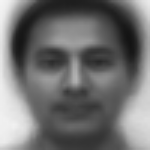

In [21]:
sumImg = None
count = 0
imgDict = {}
meanFace = None
for path in sorted(glob.glob('croppeddataset/train/*')):
  filepathlist = os.path.basename(path).split(".")
  subject = filepathlist[0]
  image = cv2.imread(path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  image = np.array(image).astype(np.int)
  if count == 0:
    meanFace = image
  else:
    meanFace += image
  count += 1
  if subject not in imgDict.keys():
    imgDict[subject] = (image, 1)
  else:
    img, cnt = imgDict[subject]
    fimg = image + img
    imgDict[subject] = (fimg, cnt + 1)

for key in imgDict.keys():
  temp = imgDict[key]
  imgDict[key] = np.divide(temp[0], temp[1]).astype(np.int)

meanFace = np.divide(meanFace, count).astype(np.int)
meanFace = np.squeeze(meanFace.reshape((image.shape[0]**2, 1)))
print(meanFace.shape)
showFaceFromVector(meanFace)

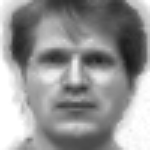

In [22]:
showFaceFromVector(imgDict['subject01']) # Just for fun!

Now, let us take each of the faces, flatten it, and then subtract them from the mean face vector in order to normalize it.

In [23]:
faceVector = [] #Stores the normalized face vectors
faceVectorNames = []
for path in sorted(glob.glob('croppeddataset/train/*')):
  image = cv2.imread(path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  image = np.array(image).astype(np.int)
  filepathlist = os.path.basename(path).split(".")
  subject = filepathlist[0]
  faceVectorNames.append(subject)
  reshapedFace = np.reshape(image, (image.shape[0]**2, ))
  reshapedFace = reshapedFace - meanFace.T
  faceVector.append(reshapedFace)

faceVector = np.squeeze(np.array(faceVector))
print(faceVector.shape)

(131, 2500)


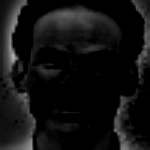

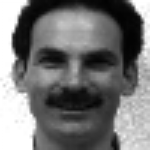

In [24]:
# Verification and checking results
index = 10
showFaceFromVector(faceVector[index])
showFaceFromVector(faceVector[index] + meanFace)

Compute the covariance matrix. The facevector is a M x N^2 matrix, where M is the number of training samples, and N^2 is the pixel area of the image. 

We need to find the eigen faces. Finding them on a N^2 x N^2 matrix will be computationally inefficient. Hence, let us find the covariance matrix for an MxM matrix and use that to compute the eigenfaces.

In [25]:
covMat = np.dot(faceVector, faceVector.T)
print(covMat.shape)

(131, 131)


Since we have the covariance matrix, lets find the eigenvalues and the eigenvectors

In [26]:
eigenValues, eigenVectors = np.linalg.eig(covMat)
print(eigenValues.shape, eigenVectors.shape)

(131,) (131, 131)


Sort the eigenvalues and eigenvectors


In [27]:
idx = eigenValues.argsort()[::-1]   
eigenValues = eigenValues[idx]
eigenVectors = eigenVectors[:,idx]
print(eigenValues.shape, eigenVectors.shape)

(131,) (131, 131)


In [28]:
eigenValues = np.absolute(eigenValues)
eigenVectors = np.absolute(eigenVectors)
print(eigenValues[0], eigenValues[1], eigenValues[-1])

262223368.3475815 169477801.25308925 7.764193807232197e-10


Find the eigenFaces!

In [29]:
eigenFaces = np.dot(faceVector.T,eigenVectors)
print(eigenFaces.shape)

(2500, 131)


In [30]:
eigenFaces = np.absolute(eigenFaces).T

Now that we have the eigenfaces, let us see how they look like!

(131, 2500)
Eigenvalue =  7.764193807232197e-10


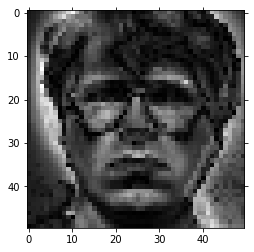

In [31]:
index = -1
eigenfaceIndexed = eigenFaces[index].reshape(image.shape)
print(eigenFaces.shape)
print('Eigenvalue = ', eigenValues[index])
showFaceFromVector(eigenfaceIndexed, True)

Let us plot the eigenvalues. We will be reducing dimensionality by retaining only a few principal components that offer the maximum variance. 


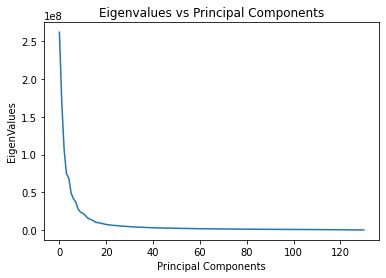

In [32]:
import matplotlib.pyplot as plt
plt.title('Eigenvalues vs Principal Components')
plt.xlabel('Principal Components')
plt.ylabel('EigenValues')
plt.plot(eigenValues)
plt.show()

### Dimensionality Reduction


Now, let us retain only the first 20 eigenfaces.

(131, 2500)
(20, 2500)
(2500,)


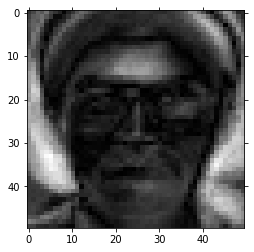

In [33]:
k = 20
chosenEigenFaces = eigenFaces[0:k]
chosenEigenValues = eigenValues[0:k]

print(eigenFaces.shape)
print(chosenEigenFaces.shape)
print(chosenEigenFaces[0].shape)
showFaceFromVector(chosenEigenFaces[0], True)

The next cell projects all of the training faces onto the eigenspaces. We represent each training face in terms of the eigenfaces, where each face is a weighted summation of the eigenfaces.

In [34]:
eigenWeights = []
for i in range(len(faceVector)):
  faceWeight = []
  for j in range(k):
    faceWeight.append(np.dot(faceVector[i], chosenEigenFaces[j]))
  eigenWeights.append(faceWeight)

eigenWeights = np.array(eigenWeights)
print(eigenWeights.shape)

(131, 20)


## Testing

In [35]:
import scipy

For a given face, normalize with respect to the mean face, and then project onto the eigenspace. Now, using the weights that are obtained during projection, compare with the training weights, and see which of the weights match closest. This will be our prediction.

In [36]:
def recognizeFace(image, subjectName, suppressImage = False):
  normalizedFace = image.reshape(meanFace.shape[0]) - meanFace
  if not suppressImage:
    showFaceFromVector(normalizedFace)
  weight = []
  for j in range(k):
    weight.append(np.dot(normalizedFace, chosenEigenFaces[j]))
  weight = np.array(weight)
  projectedFace = np.dot(weight,chosenEigenFaces)

  diff = np.linalg.norm(eigenWeights - weight, axis = 1)
  prediction = diff.argmin()
  return faceVectorNames[prediction], subjectName == faceVectorNames[prediction]

Let us finish up by linking our detector and the recognizer fully!Putting the detector and face recognizer together:

In [37]:
face_cascade = cv2.CascadeClassifier('haarTrainedCustom/cascade.xml')

In [64]:
success = 0
failures = 0
total = 0
faceDetectionFailures = 0
faceDetectionSuccess = 0
for path in sorted(glob.glob('dataset/test/*'),reverse = True):
  total += 1
  filepathlist = os.path.basename(path).split(".")
  subject = filepathlist[0]
  im = cv2.imread(path)
  im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
  faces = face_cascade.detectMultiScale(im, 1.3, 5)
  for (x,y,w,h) in faces:
    im = cv2.resize(im[y-20:y+h+20, x-10:x+w+10], (50,50))
  if len(faces) == 0:
    faceDetectionFailures += 1
    continue
  else:
    faceDetectionSuccess += 1

    prediction, isSuccess = recognizeFace(im, subject, suppressImage = True)
    if isSuccess:
      success += 1
    else:
      failures += 1
print('Successes of both Detector and Recognition = ', success)
print('Detection Failures = ',  faceDetectionFailures, '| Recognition Failures = ', failures)
print('Total Pictures= ', total)
print('Accuracy of Face Recognizer = ', success*100/(failures + success))
print('Accuracy of Face Detector = ', faceDetectionSuccess*100/(total))

Successes of both Detector and Recognition =  21
Detection Failures =  0 | Recognition Failures =  13
Total Pictures=  34
Accuracy of Face Recognizer =  61.76470588235294
Accuracy of Face Detector =  100.0


We get the following results:

```
Successes of both Detector and Recognition =  12
Detection Failures =  6 | Recognition Failures =  16
Total Pictures=  34
Accuracy of Face Recognizer =  42.857142857142854
Accuracy of Face Detector =  82.3529411764706
```

This may vary since the train and test split is shuffled.
As we can see, the results are not very promising. This is largely because of the low number of training sets given for the detector. 

Lets run it using a better haar cascade classifier and see if the rate improves. Run the next cell, and then rerun the previous cell

In [63]:
face_cascade = cv2.CascadeClassifier('haar/haarcascade_frontalface_default.xml')

We get the following results
```
Successes of both Detector and Recognition =  21
Detection Failures =  0 | Recognition Failures =  13
Total Pictures=  34
Accuracy of Face Recognizer =  61.76470588235294
Accuracy of Face Detector =  100.0
```

This is much better than before!

We will expect accuracy to increase if we run it with a larger dataset.

## Some Visualizations


Predicted Correctly =  subject15


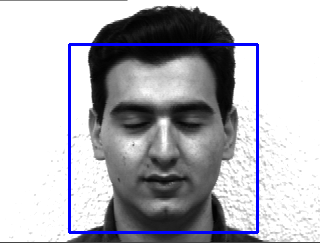

Predicted Correctly =  subject14


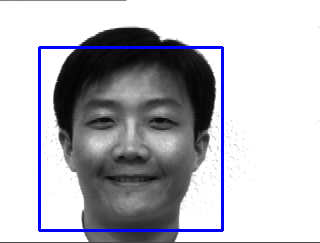

Predicted Correctly =  subject13


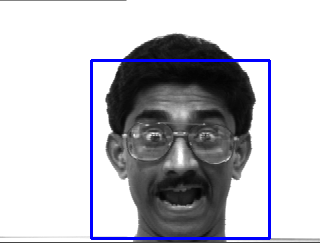

Predicted Correctly =  subject13


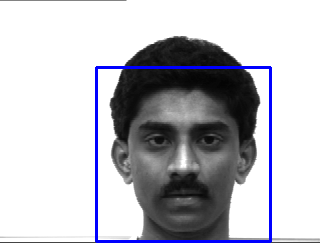

Predicted Correctly =  subject12


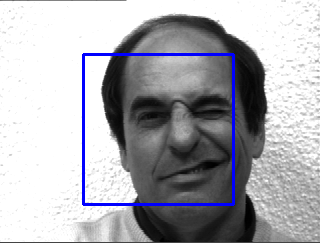

Predicted Correctly =  subject10


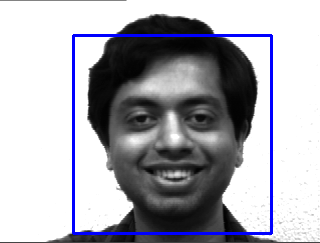

Predicted Correctly =  subject09


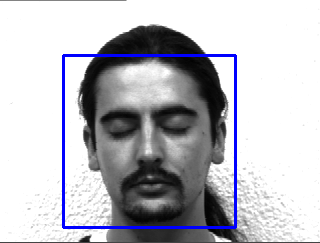

Predicted Correctly =  subject07


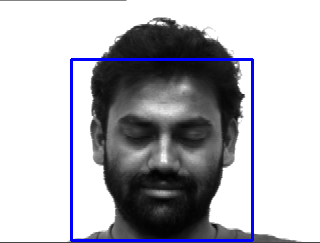

Predicted Correctly =  subject07


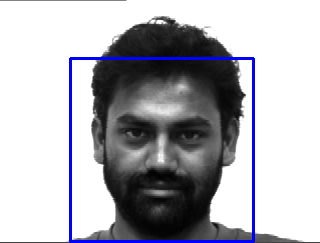

Predicted Correctly =  subject06


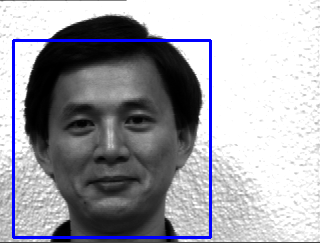

Predicted Correctly =  subject05


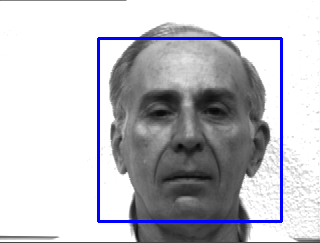

Predicted Correctly =  subject04


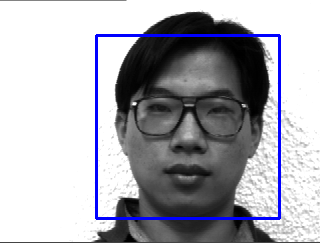

Predicted Correctly =  subject03


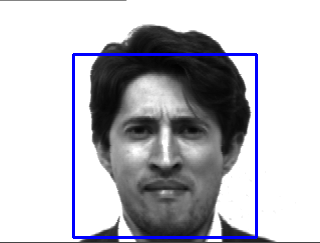

In [60]:
face_cascade = cv2.CascadeClassifier('haarTrainedCustom/cascade.xml')
for path in sorted(glob.glob('dataset/test/*'),reverse = True):
  total += 1
  filepathlist = os.path.basename(path).split(".")
  subject = filepathlist[0]
  im = cv2.imread(path)
  orig = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
  faces = face_cascade.detectMultiScale(orig, 1.3, 5)
  if len(faces) > 0:
    (x, y, w, h) = faces[0]
    im = cv2.resize(orig[y-20:y+h+20, x-10:x+w+10], (50,50))
  if len(faces) == 0:
    faceDetectionFailures += 1
    # continue
  else:
    faceDetectionSuccess += 1
    prediction, isSuccess = recognizeFace(im, subject, suppressImage = True)
    if isSuccess:
      success += 1
      orig = cv2.cvtColor(orig, cv2.COLOR_GRAY2BGR)
      cv2.rectangle(orig, (x - 20, y - 20), (x + w + 20, y + h + 20), (255,0,0), 2)
      print('Predicted Correctly = ', prediction,)
      cv2_imshow(orig)
      
    else:
      failures += 1
    

Illustrating the concept of an integral image:


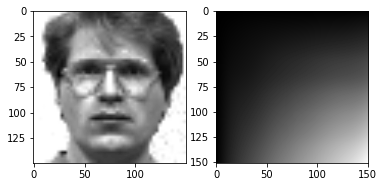

In [40]:
tempimg = cv2.imread('croppeddataset/train/subject01.glasses.0.png')
tempimg = cv2.cvtColor(tempimg, cv2.COLOR_BGR2GRAY)
tempimg = cv2.resize(tempimg, (150,150))
intimg = cv2.integral(tempimg)
plt.subplot(1,2,1)
plt.imshow(tempimg, cmap = 'gray')

plt.subplot(1,2,2)
plt.imshow(intimg, cmap = 'gray')